In [1]:
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pprint import pprint
from scipy.optimize import curve_fit

import src.io as sio
import src.preprocessing as spp
import src.fitting as sft
import ipympl

In [2]:
AFM_FOLDER = sio.get_folderpath("20201009_FirstPumpdown")

# Variation of frequency sweeps with pumpdown

## Variation of Q-factor and resonance frequency
Q-factor and fres increase with increasing vacuum

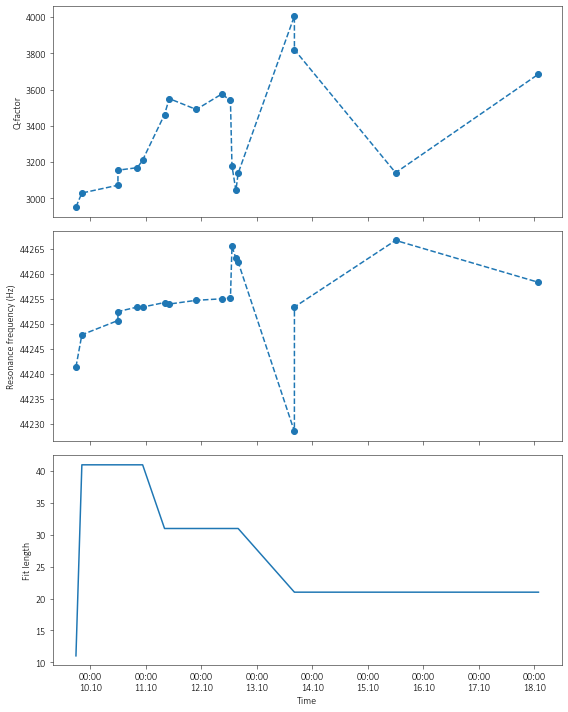

In [34]:
%matplotlib inline
d = spp.get_all_frq_sweeps(AFM_FOLDER, plot=False)
Q = []
f_res = []
dates = []
fitlens = []
for file in d:
    Q.append(d[file]['params']['Q'])
    f_res.append(d[file]['params']['f_res (Hz)'])
    dates.append(datetime.strptime(d[file]['params']['Date'], '%d.%m.%Y %H:%M:%S'))
    fitlens.append(d[file]['params']['Fit length'])

dates = matplotlib.dates.date2num(dates)

fig, (ax1, ax2, ax3)  = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
ax1.plot_date(dates, Q, "o--")
ax1.set_ylabel("Q-factor")

ax2.plot_date(dates, f_res, "o--")
date_form = DateFormatter("%H:%M\n%d.%m")
ax2.xaxis.set_major_formatter(date_form)
ax2.set_ylabel("Resonance frequency (Hz)")
fig.tight_layout()

ax3.plot(dates, fitlens)
ax3.xaxis.set_major_formatter(date_form)
ax3.set_ylabel('Fit length')
ax3.set_xlabel("Time")

fig.tight_layout()
#sio.savefig("Varation_of_q_and_fres_fitlen_with_vacuum")

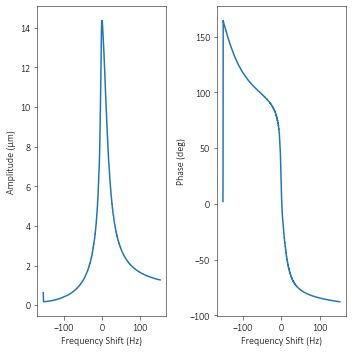

In [35]:
params, data = sio.read_dat(AFM_FOLDER+"frq-sweep007")
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(5, 5))

ax1.plot(data["Frequency Shift (Hz)"], data["Amplitude (m)"]/1e-6)
ax1.set_xlabel("Frequency Shift (Hz)")
ax1.set_ylabel("Amplitude (µm)")

ax2.plot(data["Frequency Shift (Hz)"], data["Phase (deg)"])
ax2.set_xlabel("Frequency Shift (Hz)")
ax2.set_ylabel("Phase (deg)")

fig.tight_layout()
#sio.savefig("frq_sweep_in_vacuum")

# Temperature monitoring (ambient)

In [18]:
df = pd.read_excel(AFM_FOLDER+"TemperatureMonitorLongTerm.xls", skiprows=3)
df["Time"] /= 1000
df = df[:600]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(df["Time"], df["Tip Holder.1"], "o-")
ax1.set_ylabel("Tip Holder (K)")

ax2.plot(df["Time"], df["Baseplate"], "o-")
ax2.set_ylabel("Baseplate (K)")
ax2.set_xlabel("Time (s)")

#sio.savefig(AFM_FOLDER, "TemperatureMonitorLongTerm.jpg")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Time (s)')

# Pressure monitoring during leaktesting (Backing)

(0.0, 0.045)

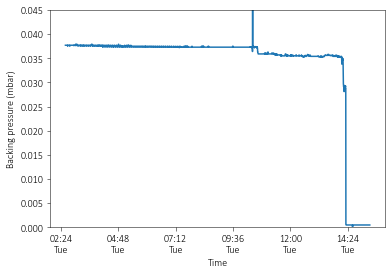

In [133]:
df = sio.read_tpg_data("PressureMonitoringLeaktesting", AFM_FOLDER)

fig, ax = plt.subplots()

myFmt = DateFormatter("%H:%M\n%a")
ax.xaxis.set_major_formatter(myFmt)

ax.plot(df["MPL_datetimes"], df["Backing"], "-")
ax.set_xlabel("Time")
ax.set_ylabel(r"Backing pressure (mbar)")
ax.set_ylim((0, 0.045))

# Pressure monitoring (after underrange on backing)

In [82]:
df4 = sio.read_tpg_data("pressure-monitoring04", AFM_FOLDER)
df5 = sio.read_tpg_data("pressure-monitoring05", AFM_FOLDER)
df6 = sio.read_tpg_data("pressure-monitoring06", AFM_FOLDER)

dfc = pd.concat([df4, df5, df6])
dfc

,Date,Time,Main,Prep,Backing,MPL_datetimes
0,15-Oct-20,12:03:08.11,9.550000e-07,7.670000e-07,0.000501,18550.502177
1,15-Oct-20,12:03:10.11,9.550000e-07,7.670000e-07,0.000501,18550.502200
2,15-Oct-20,12:03:12.11,9.550000e-07,7.670000e-07,0.000501,18550.502223
3,15-Oct-20,12:03:14.11,9.550000e-07,7.670000e-07,0.000501,18550.502247
4,15-Oct-20,12:03:16.16,9.550000e-07,7.670000e-07,0.000501,18550.502270
...,...,...,...,...,...,...
12245,18-Oct-20,21:46:21.09,6.910000e-07,5.560000e-07,0.000501,18553.907189
12246,18-Oct-20,21:46:31.09,6.910000e-07,5.550000e-07,0.000501,18553.907304
12247,18-Oct-20,21:46:41.09,6.910000e-07,5.560000e-07,0.000501,18553.907420
12248,18-Oct-20,21:46:51.09,6.910000e-07,5.550000e-07,0.000501,18553.907536


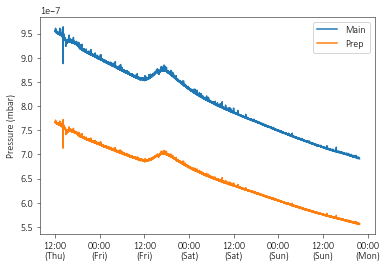

In [55]:
fig, ax = plt.subplots()
myFmt = DateFormatter("%H:%M\n(%a)")
ax.xaxis.set_major_formatter(myFmt)
ax.plot(dfc["MPL_datetimes"], dfc["Main"], label="Main")
ax.plot(dfc["MPL_datetimes"], dfc["Prep"], label="Prep")
ax.set_ylabel("Pressure (mbar)")
ax.legend()

## Future extrapolation (linear model)

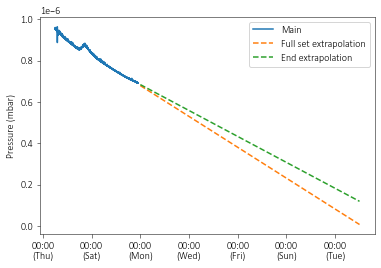

In [125]:
def linear_fit(x, a, b):
    return a + b * x

fig, ax = plt.subplots()
myFmt = DateFormatter("%H:%M\n(%a)")
ax.xaxis.set_major_formatter(myFmt)

ax.plot(dfc["MPL_datetimes"], dfc["Main"], label="Main")

start = datetime.datetime.strptime("19-Oct-20", "%d-%b-%y")
end = datetime.datetime.strptime("29-Oct-20", "%d-%b-%y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end - start).days)]
dt_series_mpl = matplotlib.dates.date2num(date_generated)

# Linear fit 1
popt, pcov = curve_fit(linear_fit, xdata=dfc["MPL_datetimes"], ydata=dfc["Main"])
#ax.plot(dfc["MPL_datetimes"], linear_fit(dfc["MPL_datetimes"], *popt))
ax.plot(dt_series_mpl, linear_fit(dt_series_mpl, *popt), "--", label="Full set extrapolation")

# Linear fit 2
dft = dfc[90000:]
popt, pcov = curve_fit(linear_fit, xdata=dft["MPL_datetimes"], ydata=dft["Main"])
#ax.plot(dft["MPL_datetimes"], linear_fit(dft["MPL_datetimes"], *popt))
ax.plot(dt_series_mpl, linear_fit(dt_series_mpl, *popt), "--", label="End extrapolation")

ax.set_ylabel("Pressure (mbar)")
ax.legend()

# Temperature Monitoring 2

In [17]:
df = pd.read_excel(AFM_FOLDER+"temperature-monitoring06.xls", skiprows=3)
df["Time"] /= 1000
df = df[:600]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(df["Time"], df["Tip Holder"], "o-")
ax1.set_ylabel("Tip Holder (K)")

ax2.plot(df["Time"], df["Baseplate"], "o-")
ax2.set_ylabel("Baseplate (K)")
ax2.set_xlabel("Time (s)")

#sio.savefig(AFM_FOLDER, "TemperatureMonitorLongTerm.jpg")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Time (s)')